In [3]:
try:
    from torchinfo import summary
except:    
    !pip install torchinfo
    from torchinfo import summary

import os
import random
from collections import Counter
from tqdm import tqdm
from PIL import Image, ImageOps

import time

import torch

from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision.transforms import ToTensor, Lambda
from torchvision.io import read_image
import torchvision.transforms as transforms
import torchvision.models as models

from IPython.display import clear_output 

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import ConfusionMatrixDisplay

torch.manual_seed(17)
RANDOM_STATE=50

import pandas as pd
import  numpy as np
import  matplotlib.pyplot as plt

In [6]:
# image_show  печать изображения path +  torch.Tensor + numpy +

def image_show(input_data):
    if isinstance(input_data, str):  # Если это  path
        img = Image.open(input_data)
    elif isinstance(input_data, torch.Tensor):  # Если это torch.Tensor
        img = input_data.permute(1, 2, 0).numpy()
    elif isinstance(input_data, np.ndarray):  # Если это numpy
        img = input_data
    elif isinstance(input_data, Image.Image):  # Если это (PIL)
        img = input_data
    else:
        raise ValueError('Invalid data format')
    
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.xticks([]) 
    plt.yticks([])
    plt.xlabel(f'размер: {np.array(img).shape}')
    plt.show()

In [7]:
# тернар cuda or mps or cpu
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


Создадим папки:
- 'data' - для аугментаций(test+train set),
- 'models' - для модели и csv-файлов.

In [8]:
os.makedirs('data', exist_ok=True) 
os.makedirs('models', exist_ok=True) 


In [10]:
# Создадим список с именами файлов, исследуемых изображений
path='images'
list_dir=os.listdir(path)
path_images=[x for x in list_dir if os.path.isfile(os.path.join(path, x))]

In [12]:

counts = Counter()
counts.update([ x[:6]for x in path_images])
print('\n',f'Общее количество документов: {len(path_images)} шт.','\n')
print('Список уникальных типов документов с подсчетом их количества')
counts


 Общее количество документов: 173 шт. 

Список уникальных типов документов с подсчетом их количества


Counter({'444___': 74, '405___': 48, '448___': 41, '402___': 9, '406_49': 1})

Распечатаем выборочно 16  документов для ознокомления.

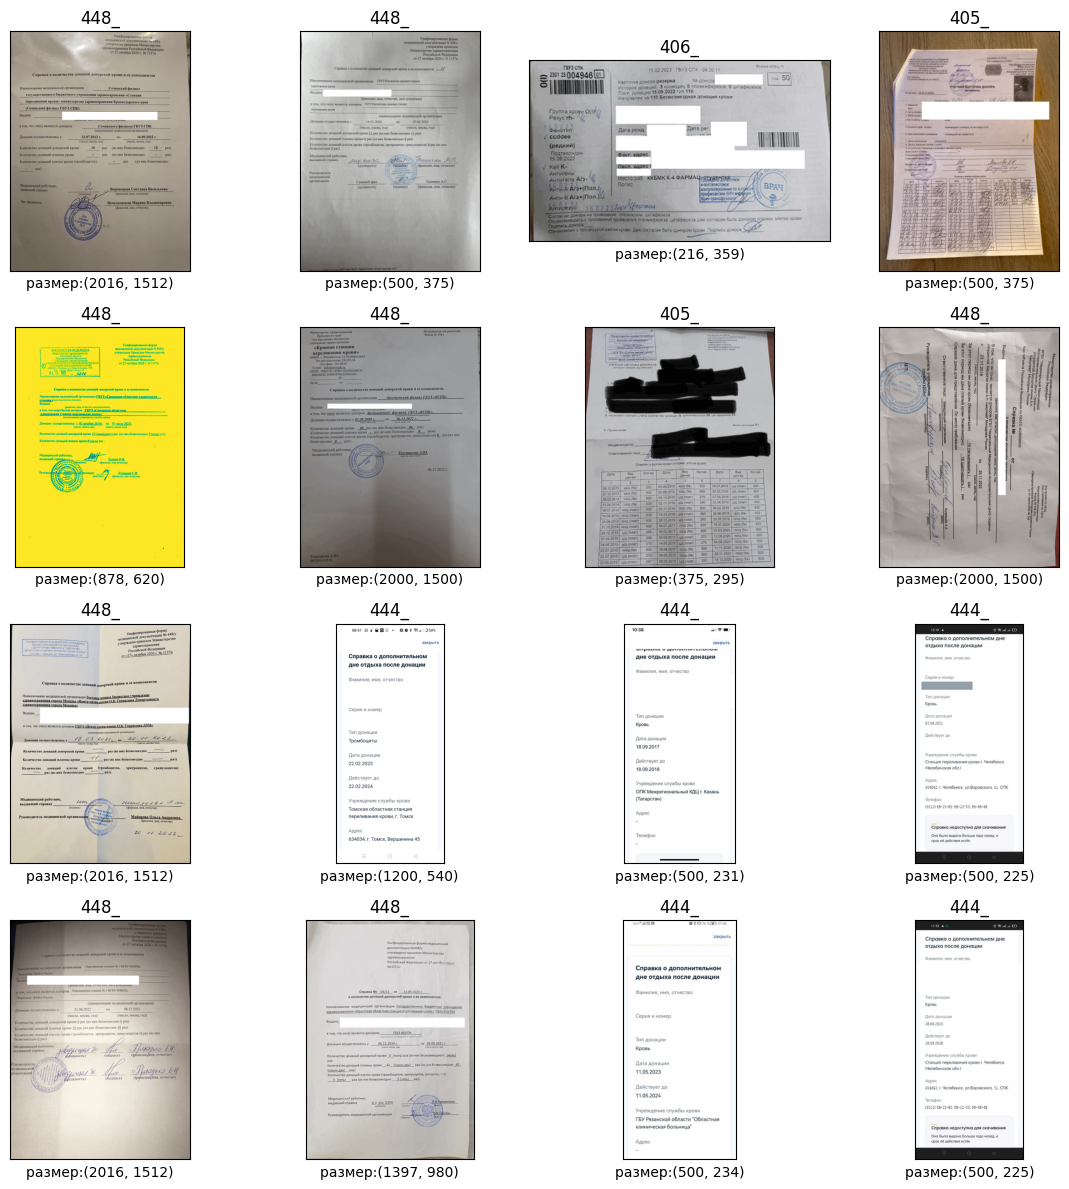

In [15]:
example_images = random.sample(path_images,16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
for i,ax in enumerate(axes.flat):
    image =Image.open(os.path.join('images',example_images[i]))
    ax.imshow(image)
    ax.set_xticks([]) 
    ax.set_yticks([])
    ax.set_xlabel(f'размер:{np.array(image).shape}')
    ax.set_title(f'{example_images[i][:4]}')
plt.tight_layout() 
plt.show()

Также  в списке справок есть документ с номером 406,  распечатаем его отдельно.

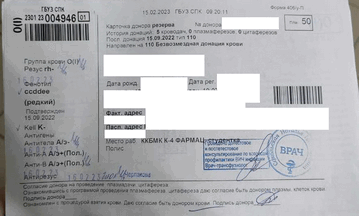

In [16]:
Image.open(os.path.join('images/',[i for i in path_images if  '406_49' in i][0]))

Из технического задания следует, что необходимо обучить модель для распознавания ориентации заведомо определённой справки № 405. Однако, в установленном датасете содержатся различные виды документов, отличающиеся по структуре и формату отображения. Наибольшее визуальное сходство
имеют справки № 405 и № 448.

Учитывая, что заказчик исключает появление документов другого формата и любые документы, не соответствующие заданному формату, будут считаться ошибкой, обучение модели на однородном наборе данных является наиболее целесообразным. Обучение модели только на справках № 405, вероятно, будет более эффективным. Однако, в условиях ограниченного набора данных (всего 48 документов), имеет смысл провести обучение и тестирование на расширенном наборе данных, включающем как справки № 405, так и справки № 448.

In [17]:
# Создадим  список, включающий названия файлов с документами № 405 и №448
path_405_448 = [x for x in path_images if '405__' in x or '448__' in x]
print(f'Общее количество  справок  № 405 и  № 448: {len(path_405_448)} шт.', '\n')

Общее количество  справок  № 405 и  № 448: 89 шт. 



In [18]:
# Разметим данные: Вертикально- 0, 90'- 1, 180'- 2, 270'- 3 ,аномалия 5'
# результат сохраним в датасете df_labels в  папке  'models'
# Если  df_labels  был создан  раннее  загружаем его.

try:
    df_labels=pd.read_csv(os.path.join('models','df_labels'))

except:
    labels={}
    for i in range(len(path_405_448)):
        clear_output(wait=True)
        a= Image.open(os.path.join('images',path_405_448[i]))
        plt.imshow(a)
        plt.show()
        print(f"Вертикально- 0, 90'- 1, 180'- 2, 270'- 3 аномалия 5'  {i}")
        a=input()
        labels[path_405_448[i]]=a
    
    clear_output()    

    df_labels = pd.DataFrame(labels.items(), columns=['names','labels'])
    df_labels['labels'] = df_labels['labels'].astype(int)


    
    df_labels.to_csv(os.path.join('models','df_labels'), index=False)

In [19]:
df_labels.head()

,names,labels
0,405___049481224374486ead31511817c052f3.png,0
1,405___087ff98ba556407fb0403a096d726c4e.png,0
2,405___2601bf92cd624eb6ac16ed3637c67f57.png,0
3,405___399c076c405d45d7a5687b64c363804f.png,1
4,405___4374492a8d5349bd9fbe60caa2dee960.png,0


Список файлов с измененными ориентациями изображений и возможными аномалиями

In [20]:
df_labels[df_labels['labels'] !=0]

,names,labels
3,405___399c076c405d45d7a5687b64c363804f.png,1
15,405___a0130627fd7b4928b1928834e0c4a628.png,3
24,405___b0eda34aa0904f279cade3e518373fd0.png,3
52,448___0d7a07e66a304764a8de469e179e0aaf.png,1
75,448___7570f37b00304f1cac7bb08cc045eb15.png,1
80,448___89bc8cf8b0274ae1b50e6620d302a1ea.png,1


Аномалий в размеченных изображениях нет,  предабработка не требуется.

Функция `images_rotation предназначена  для создания аугментаций и разметки изображения,
возвращает словарь  labels { name: label}

Функция `images_rotation`принимает аргументы:
- data - название файла с изображением 
- label - метка, характеризующая ориентацию изображения(Вертикально- 0, 90'- 1, 180'- 2, 270'- 3 )

Выполняет следующие действия:
В цикле i от 0 до 3 ( значения  меток)
- загружает  изображение - img;
- ориентирует его с учетом входной метки в нужное положение 
- составляет новое имя, добавляя  _i перед расшиением 
- записывает  в папку 'data' файл с новым именем
- добавляет  элемент в словарь

In [21]:
# Создадим датафрейм df_labels с названиями файлов и соответствущими им  меткам, запишем его в 'data'

def images_rotation(data, label):
    labels={}
    for i in range(4):
        img=Image.open(os.path.join('images',data))
        img= img.rotate(90*(label-i))  
        
        filename, ext = os.path.splitext(data)
        new_name = f'{filename}_{i}{ext}'
        img.save(os.path.join('data',new_name))
        labels[new_name]=i
    return labels                               

Либо загружаем ранее созданный датасет df_labels_final (предполагается наличие сформированных аугментаций изображений), либо выполняем код, который создает набор аугментаций с помощью функции images_rotation и формирует итоговый датасет df_labels_final с названиями файлов и соответствующими метками.

In [22]:

try:
    df_labels_final=pd.read_csv(os.path.join('models','df_labels_final'))
    
# При успешно загруженном датасете проверяем  наличие всех документов, указанных в df_labels_final
# При отсутствии самого датасета или неполного списка документов в нем, инициализируем код,
# генерирующий набор необходимых аугментаций.
    for i in df_labels_final['name']:
        if not os.path.isfile(os.path.join('data',i)):
            raise FileNotFound


except:                                
    labels={}
    for i in range(len(df_labels)):
        data,label = df_labels.loc[i,'names'], df_labels.loc[i,'labels']
        labels.update(images_rotation(data, label))
        
    df_labels_final = pd.DataFrame(labels.items(), columns=['name','labels'])
    
    df_labels_final.to_csv(os.path.join('models','df_labels_final'), index=False)

In [23]:
df_labels_final.head()

,name,labels
0,405___049481224374486ead31511817c052f3_0.png,0
1,405___049481224374486ead31511817c052f3_1.png,1
2,405___049481224374486ead31511817c052f3_2.png,2
3,405___049481224374486ead31511817c052f3_3.png,3
4,405___087ff98ba556407fb0403a096d726c4e_0.png,0


In [24]:
df_labels_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356 entries, 0 to 355
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    356 non-null    object
 1   labels  356 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.7+ KB


### 2. Подготовка данных

In [25]:
# annotations_file- датафрейм  с метеками и соответствующих им  именами  файлов .
# img_dir - папка  с файлами  изображений
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        to_tensor = transforms.ToTensor()
        # image = read_image(img_path)
        image=Image.open(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return to_tensor(image), label

In [34]:
# трансформация для тренировочных данных
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.RandomApply([transforms.RandomRotation(10)], p=0.3),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.3,  # Изменение яркости в диапазоне от 0.7 до 1.3
                                                  contrast=0.3,)], p=0.5, ),
    transforms.RandomApply([transforms.RandomAffine(degrees= 0, translate=(0.1, 0.1) )], p=0.5)
                       
    # transform = transforms.RandomCrop(size=(224, 224)
]) 

# трансформация  тестовых данных
transform_test_valid =transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224))
 ])  

# кодирование меток
target_transform=Lambda(lambda y: torch.zeros(4, dtype=torch.float).scatter_(0, torch.tensor(y), torch.tensor(1,dtype=torch.float)))

Разделим данные на тренировочные, валидационные,  тестовые.

In [35]:
df_train, df_test= train_test_split(df_labels_final, random_state=RANDOM_STATE, test_size=0.4)
df_test, df_valid = train_test_split(df_test,random_state=RANDOM_STATE, test_size=0.5)

In [36]:
BATCH_SIZE=32

In [37]:
dataset_train = CustomImageDataset(annotations_file=df_train,
                                   img_dir='data',
                                   transform=transform_train,
                                   target_transform=target_transform
                                  )
dataloader_train =DataLoader( dataset_train,batch_size=BATCH_SIZE, shuffle=True)

In [38]:
dataset_valid = CustomImageDataset(annotations_file=df_valid,
                                   img_dir='data',
                                   transform=transform_test_valid,
                                   target_transform=target_transform
                                  )
dataloader_valid =DataLoader( dataset_valid,batch_size=BATCH_SIZE, shuffle=True)

In [39]:

#  В тестовых данных batch_size примем равным размеру данных
dataset_test = CustomImageDataset(annotations_file=df_test,
                                   img_dir='data',
                                   transform=transform_test_valid,
                                   target_transform=target_transform
                                  )
dataloader_test =DataLoader( dataset_test,batch_size=len(dataset_test), shuffle=True)

### 3. Создание модели

Для обучения будем использовать модель resnet50,  обученную на на стандартном наборе данных.
Заменим последний слой на nn.Linear(num_features, 4) для адоптации  к нашей задаче.

In [40]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.model= models.resnet50(weights='DEFAULT')
        num_features =self.model.fc.in_features # количество  входных признаков
        self.model.fc=nn.Linear(num_features, 4)

    def forward(self, x):
       
        logits = self.model(x)
        return logits

In [41]:
model = NeuralNetwork().to(device)
print(model)
print(f'device :{next(model.parameters()).device}','/n')

NeuralNetwork(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [42]:
summary(model, input_size=(1,3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
NeuralNetwork                                 [1, 4]                    --
├─ResNet: 1-1                                 [1, 4]                    --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         128
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 256, 56, 56]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 56, 56]          75,008
│    │    └─Bottleneck: 3-2                   [1, 256, 56, 56]          70,400
│    │    └─Bottleneck: 3-3                   [1, 256, 56, 56]          70,400
│    └─Sequential: 2-6                        [1, 512, 28, 28]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 28, 28]          379,392

In [43]:
 next(model.parameters()).device 

device(type='cpu')

### 4 Оптимизация параметров

In [44]:
LEANING_RATE = 1e-4
batch_size = dataloader_train.batch_size


print(f'batch_size: {batch_size}')

batch_size: 32


In [45]:
# Инициализация функции  потерь
loss_fn = nn.CrossEntropyLoss()
# Инициализация оптимизатора
optimizer = torch.optim.Adam(model.parameters(), lr=LEANING_RATE)

`f1_score_custom` пользовательская функция для расчета F1

In [49]:
# y_true тензор  с метками one-hot
# y_pred тензор  с предсказаниями
def f1_score_custom(y_true, y_pred): 
    y_true = y_true.argmax(1).cpu().numpy()
    y_pred = nn.Softmax(dim=1)(y_pred).argmax(1).cpu().numpy()
    f1=f1_score(y_true, y_pred,average='micro')
    #print ('f1')
    return f1
    

In [57]:
# Круг для трейна
def train_loop(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader_train)
    total_loss = 0
    f1_score = 0
    model.train()
    for  X, y in dataloader:
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X) # возвращает логиты!
        loss = loss_fn(pred, y) # nn.CrossEntropyLoss()(with softmax)

        # Backpropagation
        loss.backward() # вычисляет градиенты
        optimizer.step() #  изменяем параметры в напралении уменьшения loss
        optimizer.zero_grad() # обнуляем  градиенты


        f1_score += f1_score_custom(y,pred)
        total_loss+=loss.item()

        
    print(f'Train - loss: {total_loss/num_batches:.5f} F1_score: {f1_score/num_batches:.5f}')


In [58]:
# круг для теста/валидации
def test_loop(dataloader, model, loss_fn):
    
    num_batches = len(dataloader_valid)
    total_loss = 0
    f1_score = 0
    
    model.eval()
    

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
            f1_score += f1_score_custom(y,pred)
            total_loss+=loss.item()
           

    
    print(f'Valid - loss: {total_loss/num_batches:.5f} F1_score: {f1_score/num_batches:.5f}')
   
    

Первое выполнениеячейки  было выполнено на платформе Kaggle, полученная модель записана
в папку 'models' - **model.pth**

In [46]:
# Загрузим  или обучим модель
try :
    model = torch.load(os.path.join('models','model.pth'), weights_only=False, map_location=device)
except:    
    epochs = 50
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(dataloader_train, model, loss_fn, optimizer)
        test_loop(dataloader_valid, model, loss_fn)
        print('-------------------------------','\n')
    print("Done")
#Предполагается локальное выполнение этого скрипта. 
#Для работы на облачных платформах (например, Kaggle, Google Colab)
#необходимо скорректировать путь записи.
    torch.save(model, os.path.join('models','model.pth'))      

### 4.Тестирование модели

In [47]:
def testing (dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    correct = 0
    f1_score = 0
    pred_list=[]
    tru_list=[]
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
           
            pred = model(X)
            
            pred_proba=nn.Softmax(dim=1)(pred).numpy()          
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
            # print(pred_proba)
            f1_score += f1_score_custom(y,pred)
            
    print(f'Test - Accuracy: {correct/size:.5f} F1_score: {f1_score/num_batches:.5f}','\n')
    print(f'ROC_AUC: {roc_auc_score(y.numpy(),
                                    pred_proba ,multi_class="ovr")}','\n')
    return  y.numpy(), pred_proba,

In [50]:
%%time
test,pred_proba=testing(dataloader_test,model,loss_fn)

Test - Accuracy: 1.00000 F1_score: 1.00000 

ROC_AUC: 1.0 

CPU times: total: 24.2 s
Wall time: 12.4 s


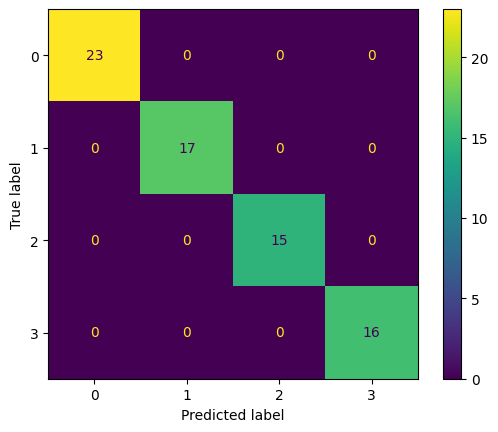

In [51]:
ConfusionMatrixDisplay.from_predictions(pred_proba.argmax(1),test.argmax(1))
plt.show()

На тестовых данных модель показала сделала предсказания для всех наблюдений без ошибок.

### 5. Пример  предсказания

In [52]:
def  model_inference(model, path):
    to_tensor = transforms.ToTensor()
    image=Image.open(path)
    image=transform_test_valid(image)
    X=to_tensor(image)
    X=X.unsqueeze(0)
    model.eval()
    with torch.no_grad():
        pred = model(X).argmax(1).numpy()
    image_show(path)
    return pred  
        

In [53]:
# выберем  случайный документ из папки 'data'
x = random.randrange(0,len(df_labels_final))
path= os.path.join('data',df_labels_final.loc[x,'name'])



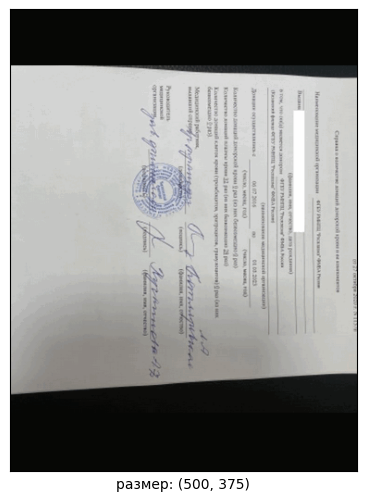

предсказание ориентации(Вертикально- 0, 90'- 1, 180'- 2, 270'- 3): 1
CPU times: total: 781 ms
Wall time: 398 ms


In [55]:
%%time
res = model_inference(model,path)
print(f"предсказание ориентации(Вертикально- 0, 90'- 1, 180'- 2, 270'- 3): {res.item()}")

### Финальный скрипт 

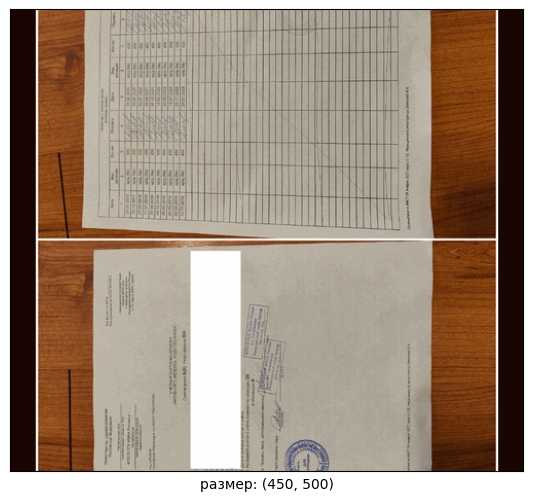

Предсказание ориентации:3


In [56]:
def model_inference_final(model, path):
    to_tensor = transforms.ToTensor()
    image=Image.open(path)
    image_trans=transform_test_valid(image)
    X=to_tensor(image_trans)
    X=X.unsqueeze(0)
    model.eval()
    with torch.no_grad():
        pred = model(X).argmax(1).numpy()
    image= image.rotate(90*pred )  
    save_path=os.path.join('transformed_images',os.path.basename(path))
    image.save(save_path)
    return pred  

    
        

x = random.randrange(0,len(df_labels_final))
path= os.path.join('data',df_labels_final.loc[x,'name'])
image_show(path)

res = model_inference_final(model,path)
print(f'Предсказание ориентации:{res.item()}')           

Напечатаем документ, ориентированный  с помощю предсказания модели.

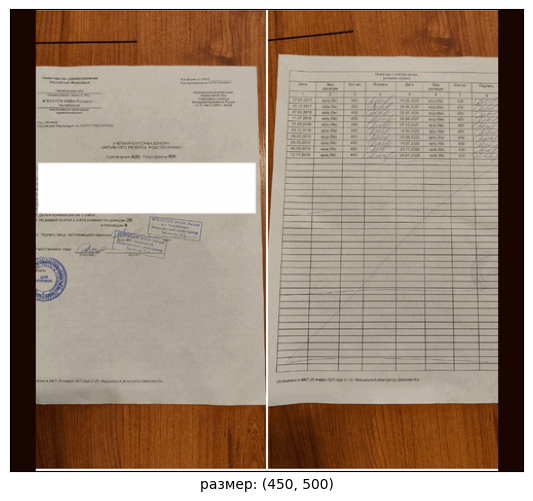

In [57]:
image_show(os.path.join('transformed_images',df_labels_final.loc[x,'name']))

In [58]:
# удалим  трансформировннный документ
os.remove(os.path.join('transformed_images',df_labels_final.loc[x,'name']))